# Gradient Boosted Trees

In [50]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import pandas as pd
import numpy

## Loading Data

As with all prior modeling, we drop `id` because it's just the identification number of each patient
We exclude `time_d` and `censor_d` because these seem unfair to include 
 in modeling since they contain information about time and censor
We chose not to include `txgrp` and `strat2` because they were derived 
(and thus highly correlated with) from other predictor variables. 

In [93]:
data = pd.read_csv("AIDSdata.csv")
data = data.drop(['id', 'time_d', 'censor_d', 'txgrp', 'strat2', 'time_d'], axis=1)

In [52]:
data.head(3)

,time,censor,tx,sex,raceth,ivdrug,hemophil,karnof,cd4,priorzdv,age
0,110,0,0,2,3,1,0,90,8.0,9.0,16
1,88,0,0,1,2,1,0,90,37.0,6.0,35
2,256,0,0,1,1,1,0,100,35.0,11.0,29


We next separate predictors and labels. Since XGBoost only allow one column for y, the censoring information is coded as negative values, as recommended by https://stackoverflow.com/questions/53562813/xgboost-cox-survival-time-entry. 

In [94]:
# predictors
X = data[['tx', 'sex', 'raceth', 'ivdrug', 
          'hemophil', 'karnof', 'cd4', 'priorzdv', 'age']]

# labels
censorL = [c for c in data.censor]
timeL = [t for t in data.time]
time_censor = list(zip(censorL, timeL))
y = [x[1] if x[0] else -x[1] for x in time_censor]

We create a train and test split, then train the models. We can't perform cross-validation in the typical way because of the time/event element. However, I personally tried a variety of values for `eta` (learning rate), `max_depth` (maximum depth of each tree), and `subsample` (fraction of observations to be random samples for each tree). From these ad-hoc trials, I chose the values which gave the highest Harrell C-statistic (which measures how well we can order patients by their survival time, where 1 is a perfect ordering).  

In [107]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
xgb_full = xgboost.DMatrix(X, label=y)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [118]:
# just by messing 
params = {
    "eta": 0.002,
    "max_depth": 2,
    "objective": "survival:cox",
    "subsample": 0.5,
    "lambda": 1
    
}
model_train = xgboost.train(params, xgb_train, 10000, 
                            evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:4.93358
[1000]	test-cox-nloglik:4.32815
[2000]	test-cox-nloglik:4.17965
[3000]	test-cox-nloglik:4.10548
[4000]	test-cox-nloglik:4.08072
[5000]	test-cox-nloglik:4.06243
[6000]	test-cox-nloglik:4.06473
[7000]	test-cox-nloglik:4.07
[8000]	test-cox-nloglik:4.0913
[9000]	test-cox-nloglik:4.0933
[9999]	test-cox-nloglik:4.11254


In [87]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

In [119]:
# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8472803347280334

The highest C-statistic I have succeeded in obtaining is 0.847. Using these best parameter values, we train a model on the full dataset. This is the model we use from here on out. 

In [120]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 2, 
    "objective": "survival:cox",
    "subsample": 0.5,
    "lambda": 1
}
model = xgboost.train(params, xgb_full, 10000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:6.55808
[1000]	test-cox-nloglik:5.88025
[2000]	test-cox-nloglik:5.68649
[3000]	test-cox-nloglik:5.55264
[4000]	test-cox-nloglik:5.44628
[5000]	test-cox-nloglik:5.3553
[6000]	test-cox-nloglik:5.2725
[7000]	test-cox-nloglik:5.19823
[8000]	test-cox-nloglik:5.12945
[9000]	test-cox-nloglik:5.06519
[9999]	test-cox-nloglik:5.00736


## Explain the Model's Predictions on the Entire Dataset with SHAP values

SHAP values are a recently developed way to perform inference on tree-based models. Their key advantage is that rather than simply giving an unsigned feature importance value, as was the case traditionally with tree-based models, SHAP values are signed. Thus, we can make inferences such as "higher values of x are associated with lower values of y."

In [121]:
shap_values = shap.TreeExplainer(model).shap_values(X)

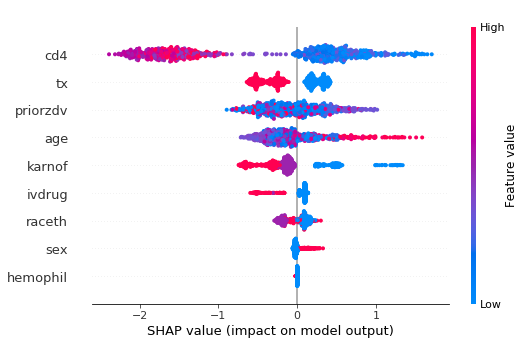

In [122]:
shap.summary_plot(shap_values, X)

In the above SHAP values plot, which replaces the familiar bar chart of feature importance for tree-based models, the predictors are listed from top to bottom in their order of importance in the model. Each dot represents one patient, and the colors represent the range of the effects of each feature within the dataset. These colors enable us to relate how changes in the values of each predictor are associated with the change in hazard. The SHAP values are plotted on the x-axis. Higher SHAP values represent higher risk of death or AIDS diagnosis associated with each explanatory variable.

We can observe that the primary risk factor for death or AIDS diagnosis is Baseline CD4 count (`cd4`) as it is the first predictor listed in the SHAP values plot. The lower the CD4 (bluer dots), the higher the risk of dying or being diagnosed with AIDS. 

The next most important risk factor is the IDV treatment, `tx`. Patients who did recieve the IDV treatment (red) have a lower risk of being diagnosed with AIDS or dying as compared to those who did not recieve the IDV treatment. 

Another interesting important risk factor is `age`. Although among younger to middle-aged people the risk of death or diagnosis is around the same, older patients are definitely more likely to die or be diagnosed with age.

A final informative risk factor is Karnofsky Performance Scale (`karnof`). As expected, the higher the Karnofsky score of a patient, the lower their risk of death or diagnosis. 

In [ ]:
## Extra Investiagion on Interes

In [ ]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X)

We produce SHAP interaction values which separate the impact of two predictors into main effects and interaction effects. Doing this, we reveal an interesting interaction effect with age and sex. 

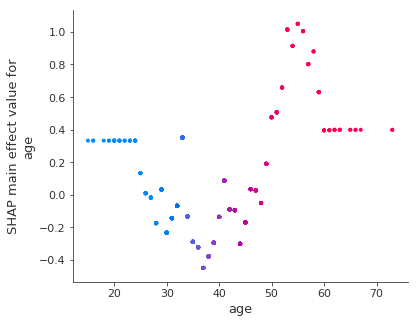

In [137]:
shap.dependence_plot(
    ("age", "age"),
    shap_interaction_values, X,
    display_features=X
)

In the plot above, we examine the main effect of age on risk of death or diagnosis. Each dot is a single individual. On the x-axis age is plotted and on the y-axis, the SHAP main effect value for age displayed. Higher SHAP values represent higher risk of death or AIDS diagnosis associated with the the interaction effect of age and sex. In general, older people are at greater risk of death or diagnosis (as alluded to in the preceeding feature importance).

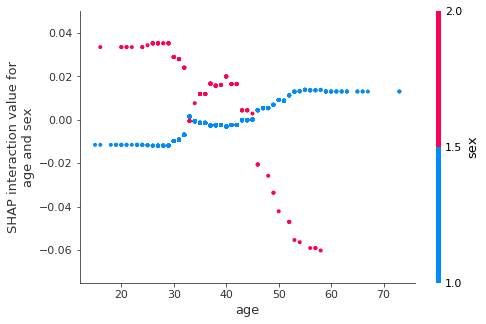

In [135]:
shap.dependence_plot(
    ("age", "sex"),
    shap_interaction_values, X,
    display_features=X
)

However, looking at the interaction effect of age and sex, we notice an interesting result. In the above plot, each dot is a single individual. On the x-axis, their age is plotted and on the y-axis, the SHAP interaction value for age and sex is displayed. Higher SHAP values represent higher risk of death or AIDS diagnosis associated with the the interaction effect of age and sex. Coloring each dot by age reveals that females are at greater risk of death or diagnosis at younger ages than males, but at older ages, males are more at risk. 